In [1]:
import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt
import numpy as np
import gym
tf.disable_eager_execution()
print(tf.__version__)

import os
#os.environ['COLAB_SKIP_TPU_AUTH'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


2.3.1


In [2]:
###

def discount_reward(reward_sequence, gamma, normalization = False):
    ans = [0]
    for ind in reversed(range(len(reward_sequence))):
        ans.append(reward_sequence[ind] + gamma*ans[-1])
    ans = np.array(ans[1:][::-1])
        
    if normalization:
        ans = ans - np.mean(ans)
    return ans

def preprocess(image):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 2D float array """ 
    image = image[35:195] # crop
    image = image[::2,::2,0] # downsample by factor of 2
    image[image == 144] = 0 # erase background (background type 1) 
    image[image == 109] = 0 # erase background (background type 2) 
    image[image != 0] = 1 # everything else (paddles, ball) just set to 1 
    return np.reshape(image.astype(np.float).ravel(), [80,80,1])

In [57]:
class PGgradient:
    tf.reset_default_graph()
    
    
    def __init__(self, state_size,state_action_size, action_size, lr, qlr,name = 'PGNetwork'):
        self.state_size = state_size
        self.action_size = action_size
        self.state_action_size = state_action_size
        self.lr = lr
        self.qlr = qlr
        
        with tf.variable_scope(name):
            with tf.name_scope("inputs"):
                self.inputs_ = tf.placeholder(tf.float32, [None, *state_size], name = 'input_')
                self.q_inputs_ = tf.placeholder(tf.float32, [None, state_action_size], name = 'q_input_')
                self.action = tf.placeholder(tf.float32, [None, action_size], name = 'acition')
                self.dc_reward = tf.placeholder(tf.float32, shape = (None), name = 'discounted_reward')
                
                #this is the placeholder for predicted q-factor, !!!cannot use self.q_fc2, since this will
                #update the parameter in the approximation coefficient as well 
                self.q_factor =tf.placeholder(tf.float32, shape = (None), name = 'q_factor')
            
            with tf.name_scope("Qfactor_fc"):
                self.q_fc1 = tf.layers.dense(inputs = self.q_inputs_, units = 64, 
                                           activation = tf.nn.relu,
                                          kernel_initializer = tf.initializers.glorot_uniform(),
                                           name = 'qfc1') 
                self.q_fc2 = tf.layers.dense(inputs = self.q_fc1, units = 1, 
                                           activation = None,
                                          kernel_initializer = tf.initializers.glorot_uniform(),
                                           name = 'qfc2') 
                
            with tf.name_scope("cov"):
                self.cov1 = tf.layers.conv2d(inputs = self.inputs_, filters = 32, kernel_size = [5,5],
                                             strides = [3,3], padding = "SAME",
                                              kernel_initializer = tf.initializers.glorot_uniform(),
                                               name = 'conv1')
                
                self.cov1_batchnorm = tf.layers.batch_normalization(self.cov1, training = True,
                                                                   epsilon=1e-5, name = 'batch_norm1')
                
                self.cov1_out = tf.nn.relu(self.cov1_batchnorm, name = 'conv1_out')
                
                
                #self.cov2 = tf.layers.conv2d(inputs = self.cov1_out, filters = 16, kernel_size = [4,4],
                #                             strides = [2,2], padding = "SAME",
                #                         kernel_initializer = tf.initializers.glorot_uniform(),
                #                           name = 'cov2')
                
                #self.cov2_batchnorm = tf.layers.batch_normalization(self.cov2, training = True,
                #                                                   epsilon=1e-5, name = 'batch_norm2')
                
                #self.cov2_out = tf.nn.relu(self.cov2_batchnorm, name = 'conv2_out')
                
            with tf.name_scope("flatten"):
                self.flatten = tf.layers.flatten(self.cov1_out)
                
            with tf.name_scope("fc"):
                
                self.fc1 = tf.layers.dense(inputs = self.flatten, units = 64, 
                                           activation = tf.nn.relu,
                                          kernel_initializer = tf.initializers.glorot_uniform(),
                                           name = 'fc2')
                
                
                self.logits = tf.layers.dense(inputs = self.fc1, units = action_size, 
                                           activation = None,
                                          kernel_initializer = tf.initializers.glorot_uniform(),
                                           name = 'logits')
                
            
            with tf.name_scope("softmax"):
                self.action_distri = tf.nn.softmax(self.logits)
                
            with tf.name_scope("loss"):
                self.logProbStateAction = tf.nn.softmax_cross_entropy_with_logits(logits = self.logits,
                                                                           labels = self.action)

                
                self.negative_weighted_logProb = tf.multiply(self.logProbStateAction, self.dc_reward - self.q_factor)
                
                self.negative_object = tf.reduce_mean(self.negative_weighted_logProb)
                
            with tf.name_scope("train"):
                self.optimizer = tf.train.RMSPropOptimizer(self.lr)
                self.train_opt = self.optimizer.minimize(self.negative_object)
            
            
        
            with tf.name_scope("Qfactor_loss"):
                #print(self.logProbStateAction)
                self.q_loss = tf.nn.l2_loss(self.q_fc2 - self.dc_reward, name = 'l2loss')
                
                self.q_object = tf.reduce_mean(self.q_loss)
                
            with tf.name_scope("Qfactor_train"):
                self.q_optimizer = tf.train.RMSPropOptimizer(self.qlr)
                self.q_train_opt = self.optimizer.minimize(self.q_object)
        

In [58]:
def batch_simu(batch_size, pg, gamma):# this is indeed the sample function from envir
    states = []
    action = []
    reward_episode = []
    reward_seq = []
    discounted_reward_seq = np.array([])
    state_action_seq = []
    state = preprocess(env.reset())
    batch = 0
    num_episode = 0
    
    while True:
        
        action_prob_distri = sess.run(pg.action_distri, feed_dict ={pg.inputs_:[state]})
        
        action_taken = np.random.choice(range(pg.action_size), p = action_prob_distri[0])
        
        action_onehot = np.zeros(pg.action_size)
        action_onehot[action_taken] = 1
        
        states.append(state)
        action.append(action_onehot) 
        state_action_seq.append(np.concatenate((state.reshape((-1,1)),action_onehot), axis = None))

        next_state, reward, done, info = env.step(action_taken+2)
        next_state = preprocess(next_state)
        reward_episode.append(reward)

        
    
        if not done:
            
            
            state = next_state
                        
            
        else:
            
            state = preprocess(env.reset())
            reward_seq += reward_episode
            discounted_reward_seq = np.concatenate((discounted_reward_seq,
                                                   discount_reward(reward_episode, gamma, True)))
            
            batch += len(reward_episode)
            
            reward_episode = []
            
            num_episode += 1
            
            if batch > batch_size:
                break
    
    
    return np.array(states), np.array(action), np.array(reward_seq), discounted_reward_seq, num_episode, np.array(state_action_seq)

In [72]:
env =  gym.make('Pong-v0')
tf.reset_default_graph()

pg = PGgradient(state_size= [80, 80,1],state_action_size = 6402, action_size=2, lr = 0.0001, qlr = 0.2)

sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)



In [73]:
#this is the main training code:


#the discounting rate
gamma = 0.99
batch_size = 2000
num_epoches = 2000
mean_reward = []

epoch = 1

saver = tf.train.Saver()
while epoch < num_epoches+1:
    
    #simulate batch
    states, action, reward_seq, discounted_reward_seq, num_episode, state_action_seq= batch_simu(batch_size, pg, gamma)
    meanRewardEpoch = sum(reward_seq)/num_episode
    mean_reward.append(meanRewardEpoch)
    

    if epoch % 20 == 0:
        print("==================================")
        print("Epoch: ", epoch, "/", num_epoches)
        print("Number of training episode with this batch: ", num_episode)
        print("Mean Reward for episode with this batch: ", meanRewardEpoch)
    
    #update the Q-factor
    cur_loss = float('inf')
    q_train_epoch = 0
    while True:
         
        next_loss = sess.run([pg.q_object], feed_dict = {pg.q_inputs_:state_action_seq,
                                            pg.dc_reward: discounted_reward_seq})
                
        if abs(next_loss[0] - cur_loss) < 1e-5:
            break
        
        sess.run([pg.q_train_opt],  feed_dict = {pg.q_inputs_:state_action_seq,
                                            pg.dc_reward: discounted_reward_seq})
        
        q_train_epoch += 1
        cur_loss = next_loss
        
        
    #print("Training Q-factor epoch: "+ str(q_train_epoch) +'; loss: '+ str(cur_loss))
    
    #get the q factor estimate for the current batch of states
    temp = sess.run([pg.q_fc2],  feed_dict = {pg.q_inputs_:state_action_seq})
    
    #run the policy gradient
    sess.run([pg.train_opt], feed_dict = {pg.inputs_: states, pg.q_inputs_:state_action_seq,
                                          pg.action: action, pg.dc_reward: discounted_reward_seq,
                                         pg.q_factor: temp}) 
    
    
    
    epoch += 1
    

KeyboardInterrupt: 

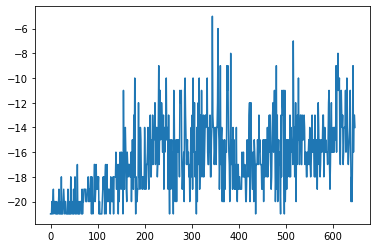

In [71]:
fig, ax = plt.subplots(1,1)

ax.plot(range(len(mean_reward)), mean_reward)

plt.show()
